# INTEGRATE Daugaard Case Study with three eology-resistivity prior models.

This notebook contains an example of inverison of the DAUGAARD tTEM data using three different geology-resistivity prior models

In [1]:
try:
    # Check if the code is running in an IPython kernel (which includes Jupyter notebooks)
    get_ipython()
    # If the above line doesn't raise an error, it means we are in a Jupyter environment
    # Execute the magic commands using IPython's run_line_magic function
    get_ipython().run_line_magic('load_ext', 'autoreload')
    get_ipython().run_line_magic('autoreload', '2')
except:
    # If get_ipython() raises an error, we are not in a Jupyter environment
    # # # # # # #%load_ext autoreload
    # # # # # # #%autoreload 2
    pass

import integrate as ig
import numpy as np
import os
import matplotlib.pyplot as plt
import h5py
hardcopy=True

## Download the data DAUGAARD data including non-trivial prior data

In [2]:
#files = ig.get_case_data(case='DAUGAARD') # Load only data
#files = ig.get_case_data(case='DAUGAARD', loadType='prior') # Load data and prior realizations
files = ig.get_case_data(case='DAUGAARD', loadType='prior_data') # Load data and prior+data realizations
#files = ig.get_case_data(case='DAUGAARD', loadType='post') # # Load data and posterior realizations
#files = ig.get_case_data(case='DAUGAARD', loadAll=True) # All of the above
f_data_h5 = files[0]
file_gex= ig.get_gex_file_from_data(f_data_h5)
# check that file_gex exists
if not os.path.isfile(file_gex):
    print("file_gex=%s does not exist in the current folder." % file_gex)

print('Using hdf5 data file %s with gex file %s' % (f_data_h5,file_gex))



Getting data for case: DAUGAARD
--> Got data for case: DAUGAARD
Using hdf5 data file DAUGAARD_AVG.h5 with gex file TX07_20231016_2x4_RC20-33.gex


In [3]:
# A1. CONSTRUCT PRIOR MODEL OR USE EXISTING
doComputePriorData = False
if doComputePriorData:
    N_use = 2000000

    f_prior_h5_list = []
    f_post_h5_list = []
    f_prior_h5_list.append('prior_detailed_invalleys_N2000000_dmax90.h5')
    f_prior_h5_list.append('prior_detailed_outvalleys_N2000000_dmax90.h5')
    
    for f_prior_h5  in f_prior_h5_list:
        print('Using prior model file %s' % f_prior_h5)

        #% plot some 1D statistics of the prior
        ig.plot_prior_stats(f_prior_h5)

        #% Compute prior data
        f_prior_data_h5 = ig.prior_data_gaaem(f_prior_h5, file_gex, N=N_use)
        f_prior_h5_list.append(f_prior_data_h5)

In [4]:
f_data_h5 = 'DAUGAARD_AVG.h5'

f_prior_data_h5_list = []
f_prior_data_h5_list.append('prior_detailed_invalleys_N2000000_dmax90_TX07_20231016_2x4_RC20-33_Nh280_Nf12.h5')
f_prior_data_h5_list.append('prior_detailed_outvalleys_N2000000_dmax90_TX07_20231016_2x4_RC20-33_Nh280_Nf12.h5')
#f_prior_h5_list.append('prior_detailed_general_N2000000_dmax90.h5_TX07_20231016_2x4_RC20-33_Nh280_Nf12.h5')
f_post_h5_list = []

N_use = 2000000

for f_prior_data_h5 in f_prior_data_h5_list:
    print('Using prior model file %s' % f_prior_data_h5)

    #f_prior_data_h5 = 'gotaelv2_N1000000_fraastad_ttem_Nh280_Nf12.h5'
    updatePostStat =True
    f_post_h5 = ig.integrate_rejection(f_prior_data_h5, f_data_h5, 
                                       N_use = N_use, 
                                       parallel=1, 
                                       updatePostStat=updatePostStat, 
                                       showInfo=1)
    f_post_h5_list.append(f_post_h5)

Using prior model file prior_detailed_invalleys_N2000000_dmax90_TX07_20231016_2x4_RC20-33_Nh280_Nf12.h5
Loaded data from DAUGAARD_AVG.h5
Data type 1: id_use=1,    gaussian, Using 11693/11693 data
Loaded data from DAUGAARD_AVG.h5
Data type 1: id_use=1,    gaussian, Using 11693/11693 data
Data type 1: gaussian, Using 11693/11693 data


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'prior_detailed_invalleys_N2000000_dmax90_TX07_20231016_2x4_RC20-33_Nh280_Nf12.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [5]:

for f_post_h5 in f_post_h5_list:
    #% Posterior analysis
    # Plot the Temperature used for inversion
    #ig.plot_T_EV(f_post_h5, pl='T')
    ig.plot_T_EV(f_post_h5, pl='EV')
    #ig.plot_T_EV(f_post_h5, pl='ND')

    #% Plot Profiles
    #ig.plot_profile(f_post_h5, i1=0, i2=2000, cmap='jet', hardcopy=hardcopy)

    #% Export to CSV
    #ig.post_to_csv(f_post_h5)
    plt.show()

In [6]:
X, Y, LINE, ELEVATION = ig.get_geometry(f_data_h5)

nd=len(X)
nev=len(f_post_h5_list)

EV_mul = np.zeros((nev,nd))

iev = -1
for f_post_h5 in f_post_h5_list:
    iev += 1
    # Read '/EV' from f_post_h5
    with h5py.File(f_post_h5, 'r') as f_post:
        print(f_post_h5)
        #EV=(f_post['/EV'][:]) 
        EV_mul[iev]=(f_post['/EV'][:])

#% Normalize EV

EV_P = 0*EV_mul
E_max = np.max(EV_mul, axis=0)

for iev in range(nev):
    EV_P[iev] = np.exp(EV_mul[iev]-E_max)

# Use annealing to flaten prob
T_EV = 10
EV_P = EV_P**(1/T_EV)

EV_P_sum = np.sum(EV_P,axis=0)
for iev in range(nev):
    EV_P[iev] = EV_P[iev]/EV_P_sum

ValueError: zero-size array to reduction operation maximum which has no identity

IndexError: index 0 is out of bounds for axis 0 with size 0

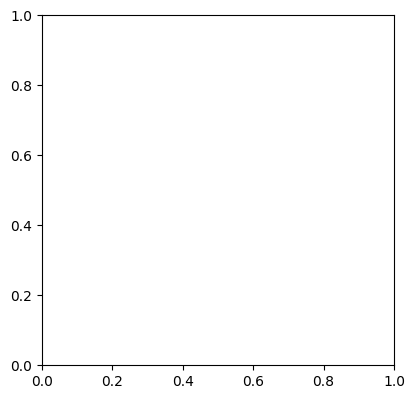

In [7]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.scatter(X, Y, c=EV_P[0], cmap='jet_r', s=3, vmin=0, vmax=1)
plt.tight_layout()
plt.axis('equal')
plt.colorbar()
plt.title('In Valleys')
plt.subplot(2,2,2)
plt.scatter(X, Y, c=EV_P[1], cmap='jet_r', s=3, vmin=0, vmax=1)
plt.tight_layout()
plt.axis('equal')
plt.colorbar()
plt.title('Out of valleys')

# Get the index of the highest value in each column in EV_P_sum
EV_mode = np.argmax(EV_P, axis=0)
EV_P_max = np.max(EV_P, axis=0)
psize = (EV_P_max-0.5)*20+0.001
plt.subplot(2,1,2)
#plt.plot(X, Y, 'k.', markersize=.1)
plt.scatter(X, Y, c=EV_mode, cmap='Set1', s=psize)
plt.axis('equal')
plt.tight_layout()
cbar = plt.colorbar(ticks=[0, 1])
cbar.set_ticklabels(['In', 'Out'])